Целью данного аналитического проекта является разработка модели машинного обчения для предсказания продолжения деятельности стартапа, а также полноценный разведочный анализ с целью формирования рекомендаций будущим создателям стартапов (какие факторы влияют на успешность или неуспешность стартапа).

Исходными данными является информация о стартапах, которые функционировали в период с 1980 по 2018 годы.

В рамках данного анализа за основу взят следующий жизненный цикл стартапа:
- Seed ("семенной") - самый длительный и трудоемкий этап
  - Pre-seed (стартап как мысль)
  - Seed (стартап как концепция)
  - MVP (базовая/минимальная версия стартапа)
  - PMF & PCF (выходит на рынок)
  - Death of valley (первые инвестиции, но пока нет прибыли)
- Launch (Запуск) - запуск продукта и активное продвижение бренда.
- Scale (Масштаб) - рост и расширение.
- Maturity (Зрелость) - стартап становится обычным бизнесом.

In [532]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler  
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer

# Подготовка и анализ данных

## Загрузка и ознакомление с данными

Загрузим имеющиеся у нас данные и предварительно рассмотрим их.

train - набор тренировочных (обучающих) данных для моделей, содержит информацию о стартапах и целевой признак status (указывает, закрылся стартап или нет).
test - набор тестовых (проверочных) данных для моделей, содержит информацию о стартапах без целевого признака.
startups - корректные данные о статусе стартапов из тестового датасета, пригодится при оценке работы лучшей модели на тестовых данных.

In [533]:
startups = pd.read_csv('DS/kaggle_startups_sample_submit_28062024.csv')
train = pd.read_csv('DS/kaggle_startups_train_28062024.csv')
test = pd.read_csv('DS/kaggle_startups_test_28062024.csv')

### Датасет train

In [534]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Отметим следующее:
- Максимальное количество записей 52516.
- Пропуски встречаются почти во всех столбцах, включая столбец name (пропущено 1 значение).
- Наибольшее количество пропусков в столбце closed_at (47 599 значений). Предварительно можем предположить дисбаланс в данных (если данных о дате закрытия меньше, то функционирующих (на момент сбора данных) стартапов было больше), но это предстоит проверить.
- Пропуски в данных об адресе, категории и сумме финансирования необходимо будет рассмотреть отдельно, предварительно сложно сказать, возможно ли будет их заменить.
- Есть замечания к типу данных столбцов (country_code, state_code, founded_at, first_funding_at и last_funding_at), их необходмо будет рассмотреть отдельно.

In [535]:
train.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


Отметим значительный разброс данных. Отдельно стоит заметить, насколько сильный перекос в данных о количестве раундов финансирования: подавляющее количество компаний ограничилось 2 раундами финансирования, но есть как минимум одна компания с 19 раундами финансирования. Возможно потребуется исключить часть данных из-за их аномальности.

In [536]:
train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


Отметим следующее:
- Обратим внимание на 5(4) строку, имеющую пропуск в funding_total_usd. У стартапа был только 1 раунд финансирования, есть все остальные данные. Вероятнее всего, пропуск в данном случае означает отсутствие полученного финансирования. Соответственно, этот и аналогичный пропуск сможем заменить нулевыми значениями.
- Обратим внимание на 4(3) строку, имеющую пропуски в данных об адресе. Действующее предприятие, имеющее достаточно данных по другим столбцам. Стоит рассмотреть возможность заполнения пропусков типичными значениями для сохранения возможно ключевых данных.
- Наконец, отметим особенности данных в столбце category_list. Часть стартапов имеют несколько указанных категорий, что не позволит в рамках анализа сгруппировать их по общим направлениям деятельности. В процессе предобработки данных вернемся к ним и оставим только одно значение (скорее всего, первое указанное).

### Датасет test

In [537]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Отметим следующее:
- Сразу обратим внимание на разницу в столбцах датасетов train и test. Так в первом есть столбец founded_at (вероятно, означает дату основания стартапа), во втором он отсутствует, но есть столбец lifetime (вероятно, означает срок жизни стартапа). Соответственно, нужно будет привести столбцы к единому виду.
- Максимальное количество записей 13125.
- Пропуски встречаются в большинстве столбцов датасета.
- Наибольшее количество пропусков в столбце funding_total_usd (2578 значений).
- Есть замечания к типу данных столбцов (country_code, state_code, first_funding_at и last_funding_at), их необходмо будет рассмотреть отдельно.

In [538]:
test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


Отмечаем схожий с ДС train широкий разброс данных.

In [539]:
test.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


Видим аналогичную картину, как и в случае ДС train.
Соответственно, в процессе предобработки данных будет необходимо проработать до анализа и подготовки модели.

### Датасет startups

In [540]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


Отметим отсутствие пропусков и корректный тип данных. Эти не требуют корректировки.

## Предобработка данных

Подготовим данные для дальнейшнего анализа.

В первую очередь рассмотрим данные на наличие неявных дубликатов.

In [541]:
print('ДС train, столбец country_code', train['country_code'].unique())
print('ДС test, столбец country_code', test['country_code'].unique())

ДС train, столбец country_code ['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN'
 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG'
 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC'
 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR'
 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN'
 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO'
 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE'
 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY' 'BMU'
 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO' 'TUN'
 'HND' 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT' 'IRN' 'GGY' 'KNA'
 'PRI' 'OMN' 'KAZ' 'JAM' 'NPL' 'ARM' 'TGO' 'RWA' 'BRN' 'JEY' 'SOM' 'CMR'
 'MNE' 'SYC' 'ZMB']
ДС test, столбец country_code ['NIC' 'USA' 'LUX' 'CAN' nan 'MYS' 'DEU' 'GBR' 'FRA' 'ITA' 'CHN' 'ARG'
 'NLD' 'IRL' 'AUS' 'CHE' 'CHL' 'ESP' 'IND' 'ISR

In [542]:
print('ДС train, столбец state_code', train['state_code'].unique())
print('ДС test, столбец state_code', test['state_code'].unique())

ДС train, столбец state_code ['25' 'CA' nan 'VA' 'NJ' 'TX' 'OR' 'FL' 'WA' 'NY' 'C7' 'AZ' '91' 'GA' 'MA'
 'PA' 'MI' '56' 'MN' 'A8' 'DE' '26' 'Q5' '7' 'RI' '11' 'C5' 'CO' '3' '23'
 '1' 'ON' 'IL' 'OH' 'K2' '2' '14' '30' 'H9' 'AL' '29' '6' 'NC' '5' '12'
 '22' 'MD' '48' 'ND' '40' 'K4' 'VT' '16' '4' 'UT' 'IN' '8' '9' '18' 'CT'
 '13' 'NV' '10' 'B8' '27' '17' 'IA' 'WI' 'L9' 'NM' 'B7' 'MO' 'BC' '21'
 'F7' 'ME' 'NH' '35' 'NS' 'C1' 'C3' 'SC' '20' 'TN' 'A6' '51' 'I7' 'LA'
 'KS' '42' 'N7' 'U8' 'I2' 'AR' '19' 'NE' '41' 'QC' 'AB' '37' '15' '97'
 'V2' 'D2' 'DC' 'A7' 'C9' 'F8' 'Y2' 'B9' 'J7' 'M9' 'G2' 'H3' 'ID' 'NB'
 '28' 'V8' '34' 'B5' 'F2' 'A9' 'Z7' '53' 'H8' 'MT' 'MB' 'KY' '61' '60'
 'B4' 'H7' '82' 'A2' 'C8' 'L3' 'B3' 'D9' 'M3' 'MS' '31' '33' '52' 'HI'
 'AK' '78' '72' 'Q4' 'Y4' 'WY' '32' 'E6' 'Q3' 'F9' '24' 'OK' 'X4' '81'
 'A1' '86' 'P4' 'E7' 'P9' '73' 'W5' 'D4' 'E9' 'A4' 'I5' 'B2' 'R3' 'N5'
 '59' 'K7' 'H5' 'H2' 'N3' 'A5' 'T5' 'G5' 'E8' 'SD' '77' '65' '36' 'WV'
 '68' 'P3' 'X5' '66' 'D8' 'C6' 'M4' '8

In [543]:
print('ДС train, столбец category_list', train['category_list'].unique())

ДС train, столбец category_list ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']


Аномальных значений, которые можно было бы принять за скрытые дубликаты, в данных столбцах не отмечаем.

Однако ранее заметили, что в данных о категории, к которой относится стартап, есть компании с несколькими категориями. Скорректируем их, оставив только первую из перечисленных категорий. Возможно после этого сможем обнаружить такие значения.

In [544]:
def new_cat(category):
    c_list = category.split('|')
    new = c_list[0]
    return new

Функция для этого готова, однако, как отмечалось ранее, в обозначенном столбце есть пропущенные значения, которые не позволят корректно применить функцию.

Рассмотрим строки с пропусками в категории.

In [545]:
train[train['category_list'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
26,The Center from Health Promotion,NaN,10000000.0,operating,NaN,NaN,NaN,NaN,1,2002-04-21,2003-11-12,2003-11-12,NaN
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03
52467,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaN
52473,Vision Software PTY,NaN,15000000.0,operating,NaN,NaN,NaN,NaN,1,1998-01-10,1999-11-02,1999-11-02,NaN


In [546]:
test[test['category_list'].isna()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
71,Pangaea Resources,NaN,NaN,AUS,2,Sydney,Sydney,1,2015-08-13,2015-08-13,7670
80,Indie Broadcast Network,NaN,NaN,NaN,NaN,NaN,NaN,1,2013-07-17,2013-07-17,1162
172,CommunitySift,NaN,750000.0,CAN,BC,Kelowna,Kelowna,1,2015-10-29,2015-10-29,2007
186,Desafío Táctico,NaN,NaN,NaN,NaN,NaN,NaN,1,2013-08-02,2013-08-02,2150
231,Nemo,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-01-28,2015-01-28,951
...,...,...,...,...,...,...,...,...,...,...,...
13010,TimeGenius,NaN,NaN,CAN,ON,Toronto,Toronto,1,2013-10-31,2013-10-31,1531
13092,Nysa Membrane Technologies,NaN,NaN,NaN,NaN,NaN,NaN,1,2007-10-05,2007-10-05,4307
13099,Microprogram Information,NaN,NaN,TWN,4,Taiwan,Taichung,1,2015-11-03,2015-11-03,8401
13107,Caspian Impact Investments,NaN,20000000.0,IND,2,Hyderabad,Hyderabad,1,2015-04-02,2015-04-02,1292


В первую очередь отметим, что всего таких данных 4,7% и 4,5% в train и test датасетах соответственно. Допустимые потери, если мы принимаем решение расстаться с этими строками.

Отметим большое количество пропусков в других стролбцах, но у некоторых есть все остальные данные, кроме категории.
В связи с этим важно понять, какие именно данные стоит считать значимыми для целей анализа и разработки модели. Т.к. ранее отметили, что у подавляющего большинства компаний раунды финансирования ограничились 1-2, сложно назвать эти данные наиболее значимыми в анализе, хотя и не стоит отметать. А вот то, в какой именно отрасли (желательно с учетом географии) смог (или не смог) занять нишу стартап, уже может являться значимым аргументом.

При этом заполнить пропуски мы можем разве что общим значением, например Other с целью максимального сохранения данных. Кроме того, возможно причиной наличия пропусков изначально являлось отсутствие подходящего выбора из предложенных. Исправим это, после чего скорректируем наименования категорий и проверим данные на неявные дубликаты.

In [547]:
#Заполняем пропуски в данных
train['category_list'] = train['category_list'].fillna('Other')
test['category_list'] = test['category_list'].fillna('Other')

In [548]:
#Оставляем только первую категорию из перечисленных
train['category_list'] = train['category_list'].apply(new_cat)
test['category_list'] = test['category_list'].apply(new_cat)

In [549]:
#Перепроверим, что данные изменены корректно
train.head(15)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [550]:
print('ДС train, столбец category_list', train['category_list'].nunique())
print(train['category_list'].unique())

ДС train, столбец category_list 708
['Online Reservations' 'Manufacturing' 'Biotechnology' 'Health Care'
 'Mobile' 'Analytics' 'Software' 'Semiconductors' 'Clean Technology'
 'Other' 'Nanotechnology' 'Customer Service' 'Banking' 'Messaging'
 'Consumers' 'Generation Y-Z' 'College Recruiting' 'Technology' 'Finance'
 'Cloud Computing' 'DIY' 'Entertainment' 'Internet' 'Advertising'
 'Fitness' 'Consumer Goods' 'Moneymaking' 'Media' 'Apps' 'Enterprises'
 'Adventure Travel' 'Travel' 'Home Owners' 'E-Commerce' 'Collaboration'
 '3D' 'Medical' 'Big Data Analytics' 'Business Services'
 'Local Businesses' 'Sports' 'Curated Web' 'Cloud Security'
 'Advanced Materials' 'Fashion' 'E-Books' 'Real Estate'
 'Social Network Media' 'Enterprise Software' 'Architecture' 'Music'
 'Broadcasting' 'Eyewear' 'Event Management' 'Healthcare Services'
 'Health and Wellness' 'Automotive' 'Education' 'Direct Sales' 'Events'
 'Digital Media' 'Pharmaceuticals' 'Games' 'Energy' 'Hardware + Software'
 'Babies' 'Home Decor

In [551]:
print('ДС test, столбец category_list', test['category_list'].nunique())
print(test['category_list'].unique())

ДС test, столбец category_list 560
['Clean Technology' 'Hospitality' 'Finance' 'Software' 'Design'
 'Biotechnology' 'Health Care' 'Consulting' 'Mobile' 'Big Data'
 'Call Center Automation' 'EdTech' 'Advertising' 'Location Based Services'
 'Medical' 'Artificial Intelligence' 'Curated Web' 'Fitness' 'Analytics'
 'Application Platforms' 'Communications Infrastructure'
 'Health and Wellness' 'Networking' 'Brokers' 'Fashion'
 'Hardware + Software' 'Dental' 'Telecommunications' 'Colleges'
 'Development Platforms' 'Education' 'Semiconductors' '3D'
 'Financial Services' 'Social News' 'Information Technology' 'E-Commerce'
 'Data Mining' 'Creative' 'Nanotechnology' 'Games' 'Bitcoin' 'Other'
 'News' 'Travel' 'Nonprofits' 'Internet' 'Cloud Computing'
 'Enterprise Software' 'Healthcare Services' 'Business Services'
 'Computers' 'Social Media' 'Real Estate' 'Entertainment' 'Photography'
 'Restaurants' 'Automotive' 'Coupons' 'Technology' 'Apps' 'Security'
 'Aerospace' 'Architecture' 'Mobile Commerce'

Получаем крайне большой перечень категорий, причем предварительно можем судить, что часть этих категорий можно сгруппировать в обощающие (например, 'Big Data Analytics', 'Business Analytics', 'Mobile Analytics', 'Predictive Analytics' в общую группу 'Analytics' или 'Big Data Analytics', 'Databases', 'Data Centers', 'Cloud Data Services' в 'Data'). В данном случае можно предложить множество вариантов группировки 708 категорий.
Также есть возможные дубликаты, например 'Biotechnology and Semiconductor' и 'Biotechnology' или 'SaaS' и 'Cloud Infrastructure'.

Рассмотрим, насколько в целом они часто встречаются.

In [552]:
train['category_list'].value_counts()

category_list
Biotechnology         3592
Software              3322
Other                 2465
E-Commerce            2173
Advertising           1926
                      ... 
Racing                   1
Space Travel             1
Swimming                 1
Video Conferencing       1
Realtors                 1
Name: count, Length: 708, dtype: int64

In [553]:
test['category_list'].value_counts()

category_list
Biotechnology       855
Software            809
Other               591
E-Commerce          566
Advertising         456
                   ... 
Bioinformatics        1
Skill Assessment      1
Web Design            1
Social Commerce       1
Outdoors              1
Name: count, Length: 560, dtype: int64

Топ-5 у test и train данных совпадает, а также есть редкие категории, которые встречаются только по одному стартапу. С другой стороны, наличие узкоспециализированных стартапов также вполне правдоподобно, их исключение нецелесообразно. Более того, в результате укрупнения возможно потерять часть данных (так, например, стартапы по SaaS могут оказаться крайне успешными, в то время как стартапы по PaaS нет, в результате чего анализ покажет искаженные значения). Однако для модели это иможет быть проблематично, учесть все варианты наименования.

Объединим часть категорий в общие для сокращения количества вариантов.

In [554]:
Biotechnology = ['Bioinformatics', 'Biometrics', 'Biotechnology and Semiconductor', 'Genetic Testing', 'Incubators']

SoftwareHardware = ['IT and Cybersecurity', 'FinTech', 'Enterprise Software', 'Hardware + Software', 'Mobile Software Tools', 
                    'Embedded Hardware and Software', 'Productivity Software', 'Meeting Software', 'Marketing Automation', 'All Markets', 
                    'Search', 'Local Search', 'Enterprise Search', 'Product Search', 'Video on Demand', 'Linux', 'Web Tools', 'Hardware', 
                    'Software', 'Navigation', 'Peer-to-Peer',  'Video Conferencing', 'Enterprise Hardware', 'Apps', 'Cloud Security', 
                    'Developer Tools', 'SaaS', 'iOS', 'CAD',  'Music Services', 'IaaS', 'MicroBlogging', 'Online Identity',  'Homeland Security',
                    'Fraud Detection',  'QR Codes', 'Web Browsers', 'Face Recognition', 'Cloud Management', 'Online Scheduling', 'Interface Design',
                    'PaaS',  'Public Safety',  'Private Social Networking', 'Forums', 'User Experience Design', 'User Interface',
                    'Infrastructure Builders', 'CRM',  'Intelligent Systems', 'Image Recognition', 'Customer Support Tools', 'Computer Vision',
                    'Photo Editing', 'Virtual Workforces', 'Web Design', 'Speech Recognition', 'Browser Extensions', 'Digital Rights Management',
                    'Internet Infrastructure', 'Chat', 'Cyber Security', 'Algorithms', 'Network Security', 'Communications Hardware', 'Development Platforms',
                    'Call Center Automation', 'Application Performance Monitoring', 'Video Streaming', 'Shared Services', 'Enterprise Application',
                    'Developer APIs', 'Web Development', 'Simulation', 'Cloud Infrastructure',  'File Sharing', 'Email', 'Internet of Things',
                    'Facebook Applications', 'Information Security', 'Cloud Computing', 'Augmented Reality', 'EDA Tools', 'Testing', 'RFID', 'Sensors',
                    'Indoor Positioning', 'Gps', 'Maps']

Commerce = ['Social Commerce', 'E-Commerce Platforms', 'E-Commerce', 'Enterprise Purchasing', 'Direct Sales', 'Wholesale', 'Sales Automation', 'Sales and Marketing',
            'Point of Sale', 'Flash Sales',  'Farmers Market', 'Vending and Concessions', 'Group Buying', 'Groceries', 'Supply Chain Management', 
           'Lifestyle Businesses', 'Marketplaces', 'Retail', 'Shopping',  'Local Commerce', 'Internet Radio Market', 'Electrical Distribution',
           'Mobile Commerce',  'Distributors', 'Custom Retail', 'Specialty Retail', 'Fmcg']

Advertising = ['Digital Signage', 'Brand Marketing', 'Email Marketing', 'Direct Marketing', 'App Marketing', 'Internet Marketing',
              'Promotional', 'Consumer Behavior', 'Cause Marketing', 'Local Advertising', 'Advertising Exchanges', 'Advertising Platforms',
              'Advertising Networks', 'Mobile Advertising',  'Social Media Advertising', 'Online Video Advertising', 'Multi-level Marketing',
              'Performance Marketing', 'Interest Graph', 'Classifieds', 'Loyalty Programs','News',  'Lead Generation', 'SEO',  'Email Newsletters',
              'Coupons', 'Ad Targeting', 'Lead Management', 'Contests', 'Discounts', 'Public Relations', 'Group Email', 'Direct Advertising']

Data = ['Big Data Analytics', 'Business Analytics', 'Mobile Analytics', 'Predictive Analytics', 'Market Research', 'Search Marketing',
        'Surveys', 'Data Mining', 'Opinions', 'Analytics', 'Data Visualization', 'Big Data', 'Data Centers', 'Cloud Data Services',
        'Graphics', 'Databases', 'Crowdsourcing', 'M2M', 'Business Information Systems', 'Photo Sharing', 'Data Center Infrastructure',
        'Personal Data', 'Data Integration', 'Identity Management', 'Knowledge Management', 'Machine Learning', 'Ediscovery', 'Estimation and Quoting',
        'Q&A',  'Data Security',  'Data Center Automation', 'Data Privacy', 'Polling']

Technologies = ['New Technologies', 'Clean Technology', 'Nanotechnology', 'Information Technology', 'Finance Technology', 'Mining Technologies', 
               '3D Technology', 'Retail Technology', 'Assisitive Technology', 'Clean Technology IT', 'Early-Stage Technology',  
                'Deep Information Technology', 'Internet Technology', 'SexTech', 'Energy', 'Manufacturing', 'Innovation Engineering', 
                'Printing', 'Heavy Industry', 'Portals', 'Space Travel', 'ICT', 'High Tech', 'VoIP', 'Semiconductors', 'Displays', 'Adaptive Equipment',
                'Robotics', '3D Printing', 'Wireless', 'Guides', 'Aerospace', 'Industrial', 'Unmanned Air Systems','Lasers', 'Mechanical Solutions',
                'Material Science', 'Industrial Automation', 'Automated Kiosk', 'Drones', 'Optical Communications', 'Batteries', 'Electronics',
                'Flash Storage',  'Semiconductor Manufacturing Equipment', 'Gadget',  'Advanced Materials']

Logistics = ['B2B Express Delivery', 'Content Delivery', 'Delivery', 'Logistics Company']

HealthCare = ['Healthcare Services', 'Health and Wellness',  'Health Care Information Technology',  'Health Diagnostics', 'Health and Insurance', 
              'Mobile Health', 'Mobile Emergency&Health', 'Health Services Industry', 'mHealth', 'Personal Health', 'Electronic Health Records',
              'Psychology', 'Elder Care', 'Child Care', 'Senior Citizens','Pharmaceuticals', 'Bio-Pharm',  'Alternative Medicine', 'Medical', 
              'Medical Devices', 'Medical Professionals', 'Independent Pharmacies', 'Doctors', 'Nutrition', 'Physicians', 'Hospitals', 'Clinical Trials',
              'Dental', 'Fertility', 'Recreation', 'Corporate Wellness', 'Veterinary', 'Resorts', 'Neuroscience', 'Life Sciences', 'Diabetes',
              'Exercise', 'Dietary Supplements', 'Assisted Living', 'Cosmetic Surgery', 'Swimming', 'Sports',  'Therapeutics',
              'Diagnostics',  'Active Lifestyle', 'Senior Health', 'Mens Specific']

Realty = ['Commercial Real Estate', 'Building Owners' , 'Realtors', 'Real Estate', 'Domains', 'Home Owners', 'Rental Housing', 
         'Utilities',  'Online Rental',  'Property Management', 'Building Products', 'Construction', 'Architecture', 'Experience Design',
         'Vacation Rentals']

Finance = ['Impact Investing', 'Debt Collecting', 'SNS', 'Banking', 'Moneymaking', 'Credit Cards', 'Billing', 'Bitcoin', 'P2P Money Transfer',
           'Monetization', 'Auctions', 'Financial Services', 'Mobile Payments', 'Payments', 'Credit', 'Brokers', 'Financial Exchanges', 'Finance', 
           'Personal Finance', 'Trading', 'Hedge Funds',  'BPO Services',  'Low Bid Auctions', 'Sponsorship', 'Accounting', 'Anything Capital Intensive',
           'Crowdfunding', 'Venture Capital', 'Consumer Lending', 'Investment Management',  'Stock Exchanges', 'Real Estate Investors']

Games = ['Kinect', 'Skill Gaming', 'Casual Games', 'Video Games', 'Educational Games', 'Social Games', 'Game', 'FreetoPlay Gaming', 'Mobile Games',
        'Game Mechanics', 'Toys', 'Console Gaming', 'Gamification', 'Online Gaming']

Mobile = [ 'Mobile Video', 'iPhone', 'iPad', 'App Stores', 'Group SMS', 'Mobile Infrastructure', 'Mobile Social', 'App Discovery', 
         'Mobile Devices', 'Mobile', 'Android', 'Mobile Security', 'Messaging', 'Mobile Shopping']

Ecology = ['Green', 'Electric Vehicles', 'Organic', 'Water Purification', 'Energy Efficiency', 'Solar', 'Recycling',
          'Commercial Solar', 'Concentrated Solar Power', 'Water', 'Energy Storage', 'Energy IT', 'Renewable Energies',
          'Air Pollution Control', 'Renewable Tech', 'Clean Energy', 'Biomass Power Generation', 'Waste Management', 'Aquaculture',
          'Environmental Innovation', 'Organic Food', 'GreenTech']

Social = ['Young Adults', 'Social Television', 'Baby Boomers',  'Social Business', 'Social Network Media', 'Social Media', 'Social News', 
          'Social Media Marketing', 'Social CRM', 'Parenting', 'Retirement', 'Social Media Management', 'Kids', 'Lifestyle', 'Social Recruiting',
          'Baby Safety', 'Generation Y-Z', 'Babies', 'Charity', 'Celebrity', 'Women', 'Religion', 'Demographies', 'Indians', 'Reputation',
          'Families',  'Social Media Platforms', 'Personal Branding', 'Non Profit', 'Funeral Industry', 'Mobility', 'Online Dating',
          'Field Support Services', 'Social Bookmarking', 'Social Travel',  'Social Fundraising', 'Match-Making', 'Travel & Tourism',
          'Ride Sharing', 'Events', 'Employment', 'Leisure', 'Artists Globally', 'General Public Worldwide', 'Nonprofits', 'Charities',
          'Communities', 'Homeless Shelter', 'Social Buying', 'Gay & Lesbian']

Education = ['Universities', 'Edutainment', 'Colleges','College Campuses', 'University Students', 'All Students', 'Alumni', 'Charter Schools',
            'K-12 Education', 'High School Students', 'High Schools',  'Online Education', 'Education', 'Music Education', 'Tutoring', 
            'Language Learning', 'Corporate Training', 'Self Development', 'EdTech', 'Training', 'College Recruiting', 'Private School']

Business = ['Human Resource Automation', 'Advertising', 'Collaboration', 'Business Services', 'Local Businesses', 'B2B', 'Risk Management',
           'Human Resources', 'Business Development', 'Insurance', 'Entrepreneur',  'Micro-Enterprises', 'Contact Centers', 'Shipping',
           'Corporate IT', 'Coworking', 'Enterprise 2.0', 'Lotteries', 'Brewing', 'Governance',  'Entertainment Industry', 'Mobile Enterprise',
           'Emerging Markets','Procurement',  'Staffing Firms', 'Recruiting', 'Employer Benefits Programs', 'Career Management', 'Business Productivity',
           'Business Intelligence', 'Small and Medium Businesses', 'Business Travelers', 'Freemium', 'Task Management', 'Service Providers',
           'Event Management', 'Enterprises', 'Internet Service Providers',  'Product Development Services', 'IT Management', 'Energy Management', 'Document Management',
           'Innovation Management', 'Contact Management', 'New Product Development', 'Enterprise Resource Planning', 'Enterprise Security',
           'Service Industries', 'Intellectual Asset Management', 'Fleet Management', 'Skill Assessment',  'Project Management',  'Customer Service',
           'Engineering Firms', 'Subscription Businesses', 'Food Processing'] 


ConsumerGoods = ['E-Books', 'Coffee', 'Jewelry', 'Wine And Spirits', 'Shoes', 'Cars', 'Audiobooks', 'Cable', 'Green Consumer Goods',
                'Limousines', 'Lingerie', 'Collectibles', 'Comics', 'Home Decor', 'Eyewear', 'Bicycles', 'Auto', 'Transportation', 'Film', 
                'Consumer Electronics', 'Beauty', 'Computers', 'Cannabis', 'Musical Instruments', 'Tea', 'Cosmetics', 'Specialty Foods', 'Baby Accessories',
                'Sporting Goods', 'Fruit', 'Textiles', 'Internet TV', 'Taxis', 'Wearables', 'Soccer', 'Watch', 'Golf Equipment', 'Television',
                'Gift Registries', 'Weddings', 'Boating Industry', 'Plumbers', 'China Internet', 'Animal Feed', 'Interior Design', 'Flowers',
                'Landscaping', 'Gift Card', 'Comparison Shopping', 'Google Glass', 'Gambling', 'Home Renovation', 'Music', 'Craft Beer',
                'Spas','Handmade', 'EBooks', 'Home & Garden', 'Concerts', 'Public Transportation', 'Music Venues', 'Gift Exchange',
                'Film Distribution', 'Automotive', 'Restaurants', 'Content Creators', 'Online Travel', 'Telecommunications', 'Broadcasting',
                'Consumer Goods', 'Fitness', 'Photography', 'Agriculture', 'Pets', 'Home Automation', 'Cooking', 'Furniture',
                'Price Comparison', 'Ticketing',  'Consumer Internet',  'Collaborative Consumption', 'Product Design', 'Lifestyle Products',
                'Film Production', 'Designers', 'DIY', 'Consumers', 'Fashion', 'Digital Entertainment', 'Reviews and Recommendations',
                'Creative Industries', 'Online Shopping',  'Entertainment']

Minerals = ['Biofuels', 'Fuel Cells', 'Oil', 'Oil & Gas', 'Oil and Gas', 'Fuels', 'Gold', 'Geospatial', 'Gas', 'Natural Gas Uses', 'Natural Resources',
           'Carbon', 'Chemicals', 'Specialty Chemicals', 'Commodities']

Other = ['Angels', 'Local', 'Art', 'Defense', 'Registrars', 'Identity', '3D', 'Hospitality', 'Advice', 'Lighting', 'Pre Seed', 'Cyber', 
        'Tourism', 'Smart Grid', 'Sex Industry',  'Postal and Courier Services', 'Nightlife', 'Licensing',  'Social + Mobile + Local',
        'Racing', 'Mass Customization',  'In-Flight Entertainment', 'Natural Language Processing', 'Human Computer Interaction', 'Certification Test',
        'Non-Tech', 'Privacy', 'Systems',  'Disruptive Models', 'English-Speaking', 'Rapidly Expanding', 'Presentations', 'Intellectual Property',
        'Parking',  'Professional Services', 'Civil Engineers', 'Outdoors', 'Infrastructure', 'Productivity', 'Real Time', 'Content Syndication', 'Farming',
        'Archiving',  'Local Based Services', 'Security', 'Location Based Services', 'Governments', 'Independent Music Labels', 'Translation',
        'Synchronization',  'Office Space', 'Subscription Service', 'Pervasive Computing', 'Digital Media', 'Humanitarian', 'Networking', 'Personalization',
        'Blogging Platforms', 'Consulting', 'Audio', 'Content', 'Startups', 'Creative', 'Outsourcing', 'Government Innovation', 'Video',
        'Distribution',  'Career Planning', 'Politics', 'Optimization', 'Storage', 'Freelancers', 'Hotels', 'Bridging Online and Offline', 
        'DOD/Military', 'Incentives',  'Law Enforcement',  'Cloud-Based Music', 'Open Source', 'Legal', 'Physical Security', 'Information Services',
        'Content Discovery', 'Publishing', 'Communications Infrastructure', 'Fantasy Sports', 'Travel', 'Internet', 'Curated Web', 'Web Hosting',
        'Adventure Travel', 'Application Platforms', 'Services', 'Media', 'Journalism', 'Online Reservations', 'Professional Networking', 'Artificial Intelligence',
        'Design', 'Darknet', 'Usability', 'Musicians']

In [555]:
train['category_list'] = train['category_list'].replace(Biotechnology, 'Biotechnology')
train['category_list'] = train['category_list'].replace(SoftwareHardware, 'SoftwareHardware')
train['category_list'] = train['category_list'].replace(Commerce, 'Commerce')
train['category_list'] = train['category_list'].replace(Advertising, 'Advertising')
train['category_list'] = train['category_list'].replace(Data, 'Data')
train['category_list'] = train['category_list'].replace(Technologies, 'Technologies')
train['category_list'] = train['category_list'].replace(Logistics, 'Logistics')
train['category_list'] = train['category_list'].replace(HealthCare, 'HealthCare')
train['category_list'] = train['category_list'].replace(Realty, 'Realty')
train['category_list'] = train['category_list'].replace(Finance, 'Finance')
train['category_list'] = train['category_list'].replace(Games, 'Games')
train['category_list'] = train['category_list'].replace(Mobile, 'Mobile')
train['category_list'] = train['category_list'].replace(Ecology, 'Ecology')
train['category_list'] = train['category_list'].replace(Social, 'Social')
train['category_list'] = train['category_list'].replace(Education, 'Education')
train['category_list'] = train['category_list'].replace(Business, 'Business')
train['category_list'] = train['category_list'].replace(ConsumerGoods, 'ConsumerGoods')
train['category_list'] = train['category_list'].replace(Minerals, 'Minerals')
train['category_list'] = train['category_list'].replace(Other, 'Other')

test['category_list'] = test['category_list'].replace(Biotechnology, 'Biotechnology')
test['category_list'] = test['category_list'].replace(SoftwareHardware, 'SoftwareHardware')
test['category_list'] = test['category_list'].replace(Commerce, 'Commerce')
test['category_list'] = test['category_list'].replace(Advertising, 'Advertising')
test['category_list'] = test['category_list'].replace(Data, 'Data')
test['category_list'] = test['category_list'].replace(Technologies, 'Technologies')
test['category_list'] = test['category_list'].replace(Logistics, 'Logistics')
test['category_list'] = test['category_list'].replace(HealthCare, 'HealthCare')
test['category_list'] = test['category_list'].replace(Realty, 'Realty')
test['category_list'] = test['category_list'].replace(Finance, 'Finance')
test['category_list'] = test['category_list'].replace(Games, 'Games')
test['category_list'] = test['category_list'].replace(Mobile, 'Mobile')
test['category_list'] = test['category_list'].replace(Ecology, 'Ecology')
test['category_list'] = test['category_list'].replace(Social, 'Social')
test['category_list'] = test['category_list'].replace(Education, 'Education')
test['category_list'] = test['category_list'].replace(Business, 'Business')
test['category_list'] = test['category_list'].replace(ConsumerGoods, 'ConsumerGoods')
test['category_list'] = test['category_list'].replace(Minerals, 'Minerals')
test['category_list'] = test['category_list'].replace(Other, 'Other')

In [556]:
train['category_list'].value_counts()

category_list
Other               9662
SoftwareHardware    8735
Business            5107
ConsumerGoods       4186
Biotechnology       3653
Technologies        3476
Commerce            2566
Data                2536
HealthCare          2263
Mobile              2120
Finance             1929
Education           1348
Games               1180
Social              1141
Health Care         1134
Realty               628
Ecology              268
Technology           231
Logistics            209
Minerals             138
Tracking               6
Name: count, dtype: int64

In [557]:
test['category_list'].value_counts()

category_list
Other               2397
SoftwareHardware    2111
Business            1263
ConsumerGoods       1042
Technologies         897
Biotechnology        867
Commerce             686
Mobile               599
Data                 589
HealthCare           576
Finance              491
Education            333
Games                314
Social               311
Health Care          282
Realty               159
Logistics             60
Ecology               58
Technology            54
Minerals              35
Tracking               1
Name: count, dtype: int64

Предсказуемо, самой популярной стала категория Other, т.к. включает в себя наиболее широкий перечень категорий.

Разберем пропуски в других столбцах датасетов.

In [558]:
#Сначала рассмотрим единственный пропуск в названии стартапа
train[train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Other,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


Остальные данные все заполнены. Маловероятно, чтобы название стартапа было ключевым данным. Заполним пропуск универсальным значением.

In [559]:
train['name'] = train['name'].fillna('No name')

Проверим гипотезу о том, что пропуски в столбце closed_at в ДС train обусловлены тем, что стартапы продолжают функционировать.

In [560]:
train[train['closed_at'].isna()]['status'].unique()

array(['operating'], dtype=object)

Действительно, все стартапы с пропусками в данном столбце являлись функционирующими на момент сбора данных.
Из этого делаем два важных вывода:
- Данные несбалансированы в колличестве открытых и закрытых стартапов.
- Данный столбец мы не можем использовать для обучения модели, так как это прямая утечка данных - если в столбце имеются значения (какие-либо), это автоматически сообщает модели о том, что стартап закрылся.

Рассмотрим второй пункт исходя из данных ДС test, где такой столбец отсутствует, однако имеется другой - lifetime. Отметим, что он куда более универсальный с точки зрения анализа, т.к. не имеет привязки к датам и одинаково ценнен как для анализа функционирующих, так и анализа закрытых стартапов (распространненым мнением считается, что большего всего шансов на закрытие имеет стартап на самом его старте).
Соответственно, введем данный столбец в ДС train вместо closed_at и founded_at.

In [561]:
#Приведем столбцы к формату дата/время
train['founded_at'] = pd.to_datetime(train['founded_at'], format='%Y-%m-%d')
train['closed_at'] = pd.to_datetime(train['closed_at'], format='%Y-%m-%d')

#Для простоты расчетов заполним пропуски в данных столбца clodes_at датой сбора данных
date = pd.to_datetime('2018-01-01', format='%Y-%m-%d')
train['closed_at'] = train['closed_at'].fillna(date)

#Расчитаем длительность жизни стартапов
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

#Удалим лишние столбцы
train = train.drop(['founded_at', 'closed_at'], axis=1)

In [562]:
train.head(15)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Other,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998
1,EarLens,Technologies,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114
4,WireTough Cylinders,Technologies,NaN,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,2791
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2012-11-12,2012-11-12,2452
6,Attensity,Data,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2014-05-14,2014-05-14,6575
7,Mesh Networks,SoftwareHardware,4300000.0,operating,USA,TX,Houston,Houston,1,2014-11-09,2014-11-09,4748
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2007-10-09,2011-04-20,5479
9,Vidatronic,Technologies,1250500.0,operating,USA,TX,Austin,College Station,2,2011-08-23,2013-03-21,2922


Длительность жизни стартапа расчитана.

Заполним пропуски в другом очевидном столбце, а именно - funding_total_usd. Пропуски, как обсуждалось ранее, заменим на 0, т.к. вероятно в данном случае пропуск означает буквально отсутствие значение, т.е. что финансирование не удалось привлечь.

In [563]:
train['funding_total_usd'] = train['funding_total_usd'].fillna(0)
test['funding_total_usd'] = test['funding_total_usd'].fillna(0)

In [564]:
#Перепроверим, что данные внеслись
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   first_funding_at   52516 non-null  object 
 10  last_funding_at    52516 non-null  object 
 11  lifetime           52516 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 4.8+ MB


Остаются пропуски, связанные с адресом стартапа.

Они могут быть связаны как с интернациональностью проекта, так и со сбоем в процессе сбора данных, а также банальным "человеческим фактором".

Рассмотрим отдельно данные, по котором нет данных даже о стране.

In [565]:
train[train['country_code'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114
12,Iberic Premium,Other,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2014-06-01,2014-06-01,714
14,Purewine,Technologies,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-08-28,2015-08-05,1461
15,paack,Business,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2015-02-01,2015-02-01,1731
16,Salesjob,Other,0.000000e+00,closed,NaN,NaN,NaN,NaN,1,2013-10-22,2013-10-22,952
...,...,...,...,...,...,...,...,...,...,...,...,...
52444,Plix,Business,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2012-01-01,2012-01-01,855
52449,ELabsEurope,Other,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,2000-10-23,2000-10-23,1208
52455,Capcom groupe,Realty,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2015-09-29,2015-09-29,891
52473,Vision Software PTY,Other,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1999-11-02,1999-11-02,7296


In [566]:
train[train['country_code'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5502 entries, 3 to 52500
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5502 non-null   object 
 1   category_list      5502 non-null   object 
 2   funding_total_usd  5502 non-null   float64
 3   status             5502 non-null   object 
 4   country_code       0 non-null      object 
 5   state_code         0 non-null      object 
 6   region             0 non-null      object 
 7   city               0 non-null      object 
 8   funding_rounds     5502 non-null   int64  
 9   first_funding_at   5502 non-null   object 
 10  last_funding_at    5502 non-null   object 
 11  lifetime           5502 non-null   int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 558.8+ KB


Отметим, что в таком случае и все остальные данные об адресе остаются пустыми, что достаточно ожидаемый результат.

Рассмотрим, как меняется картина, если код страны известен, но пропущены значения по остальным данным адреса.

In [567]:
train[pd.notnull(train['country_code']) & train['state_code'].isna() & train['region'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
50,Tripalocal,Other,850000.0,operating,AUS,NaN,NaN,NaN,1,2015-06-01,2015-06-01,1461
105,Amp'd Mobile,Mobile,374000000.0,closed,USA,NaN,NaN,NaN,4,2005-08-08,2007-03-21,1972
324,Cloud Health Care,Other,50000.0,closed,RUS,NaN,NaN,NaN,1,2012-02-01,2012-02-01,728
344,Meiaoju,Other,8130000.0,operating,CHN,NaN,NaN,NaN,1,2014-03-23,2014-03-23,1372
400,Xmetrics,Other,1000000.0,operating,ITA,NaN,NaN,NaN,1,2014-10-16,2014-10-16,1301
...,...,...,...,...,...,...,...,...,...,...,...,...
51952,Cloud Ninjas,Data,50000.0,operating,BEL,NaN,NaN,NaN,1,2014-06-12,2014-06-12,1292
51969,xCloud,Mobile,806018.0,operating,CHN,NaN,NaN,NaN,2,2014-04-01,2015-01-27,2983
51975,Brian Industries,Business,0.0,closed,GBR,NaN,NaN,NaN,1,2010-01-01,2010-01-01,686
52102,Guaam Method,ConsumerGoods,64189.0,operating,KOR,NaN,NaN,NaN,1,2013-05-08,2013-05-08,1699


Визуально нет ничего общего между такими стартапами, как и в случае, когда отсутствует код страны. Можем предположить, что либо данные были утеряны, либо стартапы не имеют точного адреса и на момент регистрации являются виртуальными проектами. Например, при наличии кода страны команда могла быть сосредоточена в рамках одной страны, а при ее отсутствии - интернациональна.

Заменим пропуски универсальным вариантом - VRT (virtual/виртуальный), опираясь на гипотезу о том, что на момент сбора данных проекты не имели адреса регистрации (и, соответственно, привязки к стране/региону/городу).

In [568]:
train['country_code'] = train['country_code'].fillna('VRT')
train['state_code'] = train['state_code'].fillna('VRT')
train['region'] = train['region'].fillna('VRT')
train['city'] = train['city'].fillna('VRT')

test['country_code'] = test['country_code'].fillna('VRT')
test['state_code'] = test['state_code'].fillna('VRT')
test['region'] = test['region'].fillna('VRT')
test['city'] = test['city'].fillna('VRT')

In [569]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   first_funding_at   52516 non-null  object 
 10  last_funding_at    52516 non-null  object 
 11  lifetime           52516 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 4.8+ MB


In [570]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Скорректируем типы данных в столбцах first_funding_at и last_funding_at, а также funding_total_usd.

In [571]:
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'], format='%Y-%m-%d')
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'], format='%Y-%m-%d')

test['first_funding_at'] = pd.to_datetime(test['first_funding_at'], format='%Y-%m-%d')
test['last_funding_at'] = pd.to_datetime(test['last_funding_at'], format='%Y-%m-%d')

Наконец, проверим данные на наличие явных дубликатов.

In [572]:
print('Количество явных дубликатов в ДС train', train.duplicated().sum())
print('Количество явных дубликатов в ДС test', test.duplicated().sum())

Количество явных дубликатов в ДС train 0
Количество явных дубликатов в ДС test 0


Явных дубликатов нет. Типы данных скорректированы, столбцы в датасетах train и test приведены к единому виду, пропуски заполнены.

Теперь можно перейти к анализу данных.

## Исследовательский анализ данных

Сначала рассмотрим, как в целом распределяются данные в датасетах по странам и сроку жизни.

Рассмотрение распределения по городам может быть актуально в рамках наиболее популярных стран, однако в таком случае на выбор может влиять множество факторов. Например, в Америке выбор штата и города может быть обусловлен налоговой базой или спецификой законодательства для конкретной отрасли. Аналогичные особенности могут быть у каждой страны. Поэтому оценим данные более укрупненно, так как в первую очередь нам необходимо определить, есть ли какие-то закономерности в данных с точки зрения продолжения их функционирования.

In [573]:
train.groupby('country_code')['country_code'].count().sort_values(ascending=False).head(10)

country_code
USA    29702
VRT     5502
GBR     2925
CAN     1540
IND     1276
CHN     1240
FRA      916
DEU      834
ISR      767
ESP      607
Name: country_code, dtype: int64

In [574]:
test.groupby('country_code')['country_code'].count().sort_values(ascending=False).head(10)

country_code
USA    7428
VRT    1382
GBR     725
CAN     369
IND     307
CHN     301
DEU     237
FRA     213
ISR     190
ESP     134
Name: country_code, dtype: int64

Рассмотрим топ-10 стран по количеству стартапов в целом.

Ожидаемо лидирует США (29 702 и 7 428 стартапов в train и test данных соответственно), наибольший объем данных приходится именно на эту страну. В данном случае возможно наличие искажения при сборе данных (например, стартапы из других стран не предоставляли информацию на тех ресурсах, с которых велся сбор данных), особенно учитывая, что второе место занимают стартапы с кодом страны VRT, т.е. те, у кого в изначальных данных страна указана не была. Однако США в целом считается признаным лидером по стартапам, т.к. предлагает развитую экосистему для начинающих предпринимателей и развитый рынок.
Третье место за Великобританией, четвертое - Канада, пятое - Индия, шестое - Китай. Индия на текущий момент выбивается в лидеры по стартапам, предлагая обширное количество "ниш" на своем быстрорастущем рынке, особенно в сфере IT, однако сделаем поправку на годы сбора данных, когда страна еще только стремилась к этому.

Соответственно, отметим в целом, что преимущественно стартапы открываются на Американском и Европейском рынках, из чего можем сделать вывод, что, как минимум, в те года именно эти страны предлагали наиболее подходящие условия.

Рассмотрим, меняется ли картина, если анализировать только те стартапы, которые закрылись (т.к. ожидаем, что если стартапов в целом по стране больше, то и закрывается больше). Однако так как масштаб у стран разный, рассмотрим данные в относительных числах.

In [575]:
((train[train['status']=='closed'].groupby('country_code')['country_code'].count())/
 (train.groupby('country_code')['country_code'].count())).sort_values(ascending=False).head(10)

country_code
SYC    1.000000
SOM    1.000000
BLM    1.000000
MKD    0.500000
RUS    0.352304
GEO    0.333333
SLV    0.333333
LIE    0.333333
BLR    0.333333
PRI    0.333333
Name: country_code, dtype: float64

Результат неожиданный. В полученном антитопе есть три страны, все стартапы которых закрылись. Это Сейшелы (SYC), Сомали (SOM) и Сен-Бартелеми (BLM). Очевидно, не самые благоприятные регионы для развития стартапов. Однако стоит учитывать, что и данных по этим районам очевидно мало, соответственно в данном случае это может быть как неблагоприятная рыночная обстановка, так и нехватка данных, т.к. регионы малосопоставимы между собой (некорректно сравнивать экономики Сен-Бартелеми, туристический регион, знаменитый белыми пляжами, причалами с яхтами и ресторанами, и Сомали, которое в результате гражданской войны на долгое время фактически прекратило свое существование как государство.

Из наиболее примечательных стран можем отметить Россию (35,2% стартапов закрылись), Грузия (33,3%) и Беларусь (33,3%). Не лучший, но и не худший результат. В данном случае также может играть роль нехватка данных. Но эмпирический опыт также подсказывает, что специфика законодательства и состояние экономики могли оказать свое влияние и вынудить начинающих предпринимателей начинать свое дело в другой стране (например, в той же Америке или Европе), т.к. так называемая "утечка мозгов" явление достаточно давнее.

Рассмотрим, есть ли закономерности или особенности распределения в данных о продолжительности жизни стартапа.

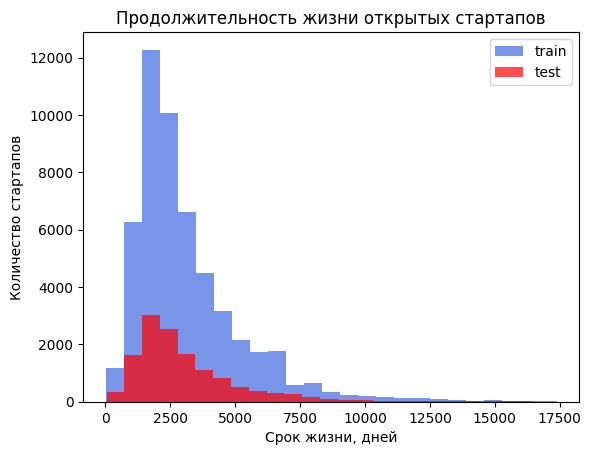

In [576]:
plt.hist(train['lifetime'], bins = 25, alpha = 0.7, label = 'train', color='royalblue')
plt.hist(test['lifetime'], bins = 25, alpha = 0.7, label = 'test', color='red')
plt.title('Продолжительность жизни открытых стартапов')
plt.xlabel('Срок жизни, дней')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

Данные в test и train распределены схожим образом. Видим явный пик около 2500 дней, рассмотрим отрезок в приближении.

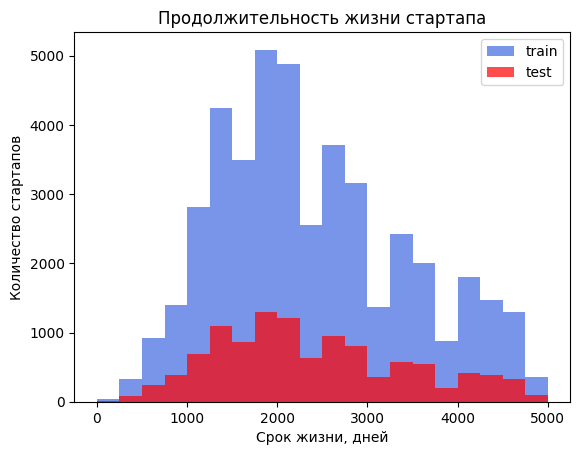

In [577]:
plt.hist(train['lifetime'], bins = 20, alpha = 0.7, label = 'train', color='royalblue', range=(0,5000))
plt.hist(test['lifetime'], bins = 20, alpha = 0.7, label = 'test', color='red', range=(0,5000))
plt.title('Продолжительность жизни стартапа')
plt.xlabel('Срок жизни, дней')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

Видим очевидный пик в районе 2000 дней (около 5,5 лет).

Т.к. данные распределены схожим образом, оценим отдельно на ДС train распределение срока жизни стартапа для двух целевых статусов.

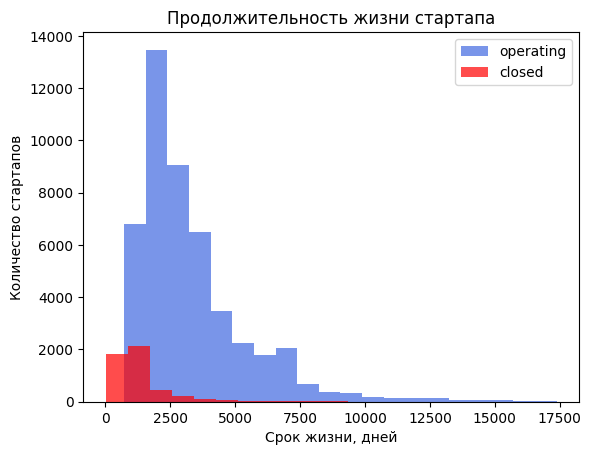

In [578]:
plt.hist(train[train['status'] == 'operating']['lifetime'], bins = 20, alpha = 0.7, label = 'operating', color='royalblue')
plt.hist(train[train['status'] == 'closed']['lifetime'], bins = 20, alpha = 0.7, label = 'closed', color='red')
plt.title('Продолжительность жизни стартапа')
plt.xlabel('Срок жизни, дней')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

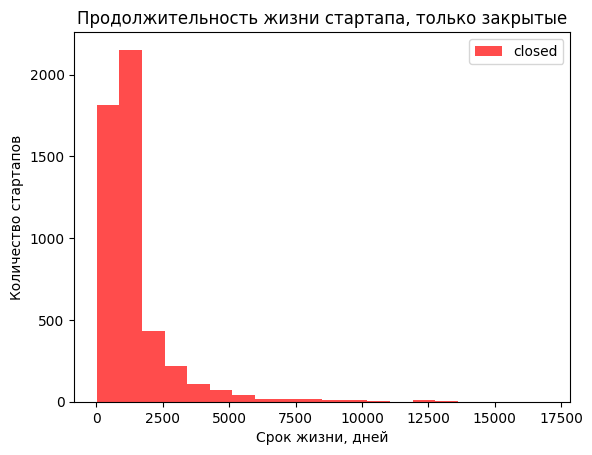

In [579]:
plt.hist(train[train['status'] == 'closed']['lifetime'], bins = 20, alpha = 0.7, label = 'closed', color='red')
plt.title('Продолжительность жизни стартапа, только закрытые')
plt.xlabel('Срок жизни, дней')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

Получаем достаточно закономерный итог, что больше всего у стартапа шансов "умереть" в первые годы жизни, но со временем все больше шансов на то, что стартап превратиться в обычный бизнес. Первые годы для стартапа всегда являются самыми рискованными, т.к. подразумевают большие личные финансовые и моральные вложения, а также сложный процесс поиска сотрудников, "бизнес-ангелов" и других людей, готовых вложить свои средства и силы в развитие чужой бизнес-идеи.

Впрочем, есть и компании, закрывшиеся после 10000 дней (более 27 лет) функционирования. В таком случае причины могут быть самые разные, включая изменения законодательства и даже смерть основателя стартапа, без которого бизнес не смог функционировать как раньше.

Однако в целом отметим, что нет принятого срока жизни, до которого стартап остается стартапом, а после превращается в обычный бизнес. Для каждого этот срок индивидуален.

В целом по графику видим ощутимое снижение количества стартапов со сроком жизни более 27 лет (10000+ дней), это очень большой срок жизни для стартапа, возможно чрезмерный. Оценим долю таких стартапов в общем количестве.

In [580]:
print('Доля стартапов со сроком жизни более 10000 дней')
print('ДС train', (train[train['lifetime']>10000]['name'].count())/len(train))
print('ДС test', (test[test['lifetime']>10000]['name'].count())/len(test))

Доля стартапов со сроком жизни более 10000 дней
ДС train 0.01582374895270013
ДС test 0.015085714285714286


По 1,5% от общего объема данных, таких компаний действительно крайне мало. Возможно, фактически они уже долгое время не являются стартапами, но продолжают числится в данных, т.к. начинало с этого.

Взаимосвязь длительности жизни стартапа и его статуса подтвердить удалось. Рассмотрим, влияет ли объем финансирования на это. Можно ожидать, что больший объем финансирования дает больший срок жизни.

Сначала рассмотрим общее распределение объема финансирования.

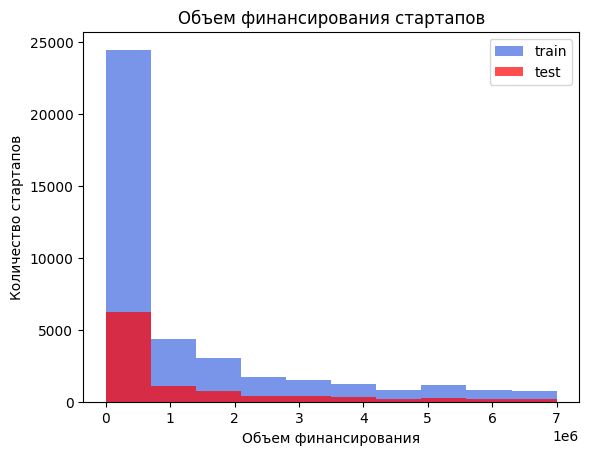

In [581]:
#Ограничиваем range, т.к. ранее отмечали большой разброс данных, вплодь до 8 миллиардов долларов
plt.hist(train['funding_total_usd'], alpha = 0.7, label = 'train', color='royalblue', range=(0, 7000000))
plt.hist(test['funding_total_usd'], alpha = 0.7, label = 'test', color='red', range=(0, 7000000))
plt.title('Объем финансирования стартапов')
plt.xlabel('Объем финансирования')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

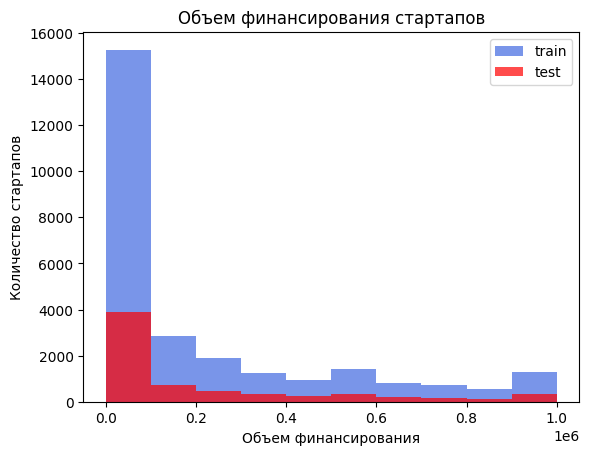

In [582]:
#В приближении, до миллиона финансирование
plt.hist(train['funding_total_usd'], alpha = 0.7, label = 'train', color='royalblue', range=(0, 1000000))
plt.hist(test['funding_total_usd'], alpha = 0.7, label = 'test', color='red', range=(0, 1000000))
plt.title('Объем финансирования стартапов')
plt.xlabel('Объем финансирования')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

Распределения в тренировочной и тестовой выборках совпадают, имеют схожий характер.

Большинство стартапов получили минимальное финансирование, в диапазоне от 0 до 100 000 долларов. Но есть ли зависимость финансирования и того, закроется ли стартап?

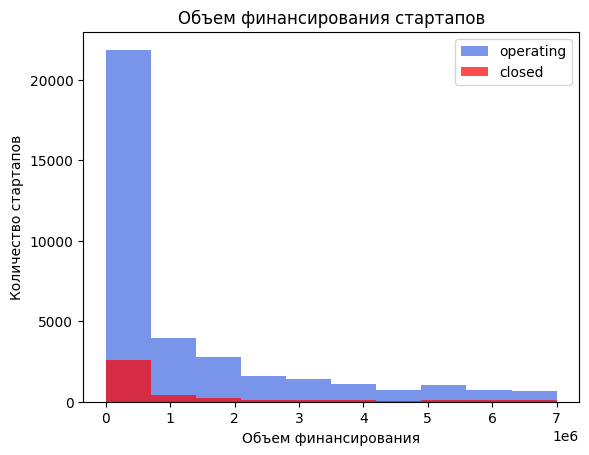

In [583]:
plt.hist(train[train['status'] == 'operating']['funding_total_usd'], alpha = 0.7, label = 'operating', color='royalblue', range=(0, 7000000))
plt.hist(train[train['status'] == 'closed']['funding_total_usd'], alpha = 0.7, label = 'closed', color='red', range=(0, 7000000))
plt.title('Объем финансирования стартапов')
plt.xlabel('Объем финансирования')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

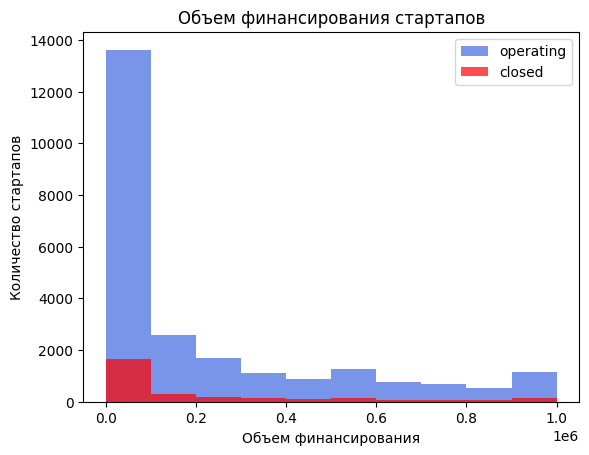

In [584]:
#В приближении, до миллиона финансирование
plt.hist(train[train['status'] == 'operating']['funding_total_usd'], alpha = 0.7, label = 'operating', color='royalblue', range=(0, 1000000))
plt.hist(train[train['status'] == 'closed']['funding_total_usd'], alpha = 0.7, label = 'closed', color='red', range=(0, 1000000))
plt.title('Объем финансирования стартапов')
plt.xlabel('Объем финансирования')
plt.ylabel('Количество стартапов')
plt.legend(loc='upper right')
plt.show()

Отметим, что гистограммы работающих и закрывшихся стартапов имеют крайне схожее поведение и распределение, что свидетельствует о том, что объем финансирования, предварительно, не оказывает значимого влияния на дальнейшую судьбу стартапа. Даже при околонулевой финансовой поддержке извне стартап имеет достаточно шансов развиться далее.

Кроме того, ранее могли отметить, что подавляющее большинство стартапов ограничились 1, максимум 2 раундами, что подтверждает тезис выше. Можем предположить, что для определенных, узконаправленных стартапов, отсутствие внешнего финансирования может стать фатальным. Однако общего тренда не наблюдаем.

In [585]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  lifetime           52516 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 4.8+ MB


Наконец, рассмотрим стартапы в разрезе категорий.

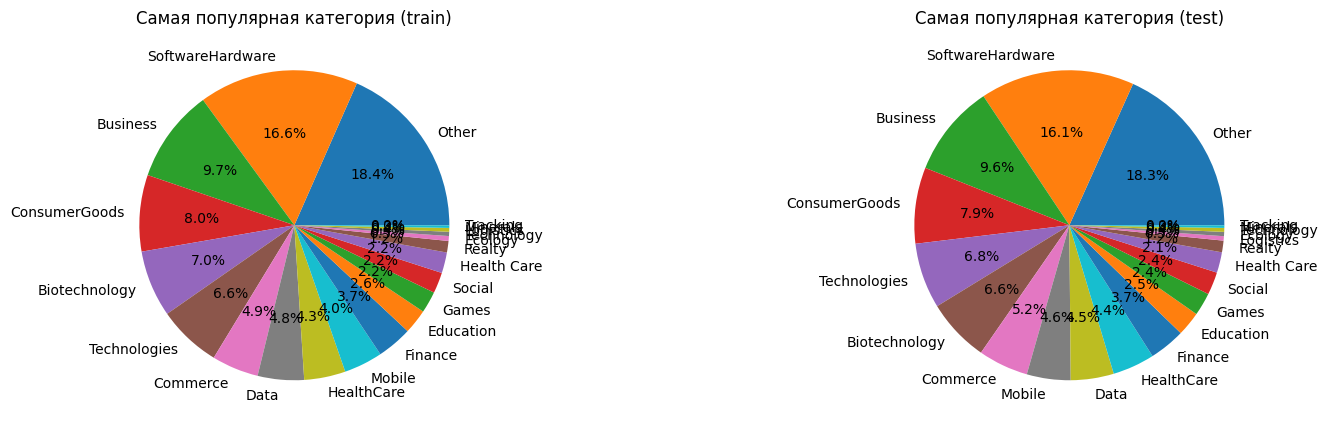

In [586]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
plt.subplots_adjust(wspace=1)

axes[0].pie(train['category_list'].value_counts(), autopct='%1.1f%%', labels=train['category_list'].value_counts().index)
axes[0].set_title('Самая популярная категория (train)')

axes[1].pie(test['category_list'].value_counts(), autopct='%1.1f%%', labels=test['category_list'].value_counts().index)
axes[1].set_title('Самая популярная категория (test)')


plt.show()

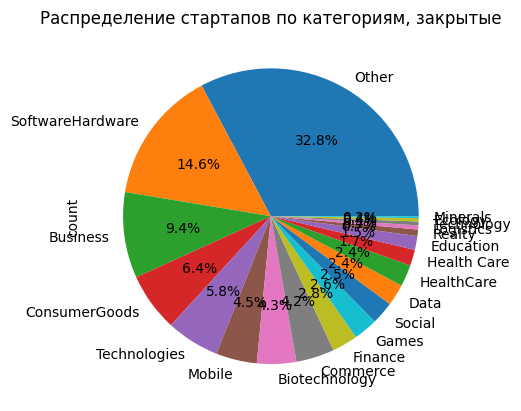

In [587]:
train[train['status']=='closed']['category_list'].value_counts().plot(kind='pie',
                                           autopct='%1.1f%%',
                                           grid=True)

plt.title('Распределение стартапов по категориям, закрытые')
plt.show()

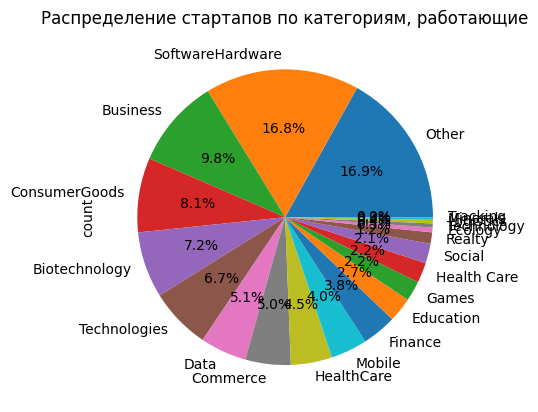

In [588]:
train[train['status']=='operating']['category_list'].value_counts().plot(kind='pie',
                                           autopct='%1.1f%%',
                                           grid=True)

plt.title('Распределение стартапов по категориям, работающие')
plt.show()

Можем сделать предварительный вывод, что прямой зависимости между категорией и шансом закрыться предварительно не выявлено. По тем категориям, по котором видим наибольшее число стартапов, по ним же и большее число закрытых (и открытых) стартапов. Лишь категория Other ощутимо выбивается, из чего можем предположить, что узкая или неконкретная специализация может повысить риски "смерти".

## Выбор итоговых признаков

Т.к. в данных о городах и регионах встречается чрезмерно большое количество данных, которые, вероятнее всего не оказывают столь значимого влияния (ввиду их большой вариативности).

Поэтому уберем их из исходных датасетов. Это позволит модели быстрее обрабатывать данные.

In [589]:
train = train.drop(['city', 'region', 'state_code'], axis=1)
test = test.drop(['city', 'region', 'state_code'], axis=1)

Также скорректируем столбцы first_funding_at и last_funding_at. Оставим лишь столбцы с годом, т.к. чрезмерная точность в датах может замедлить модель или привести к ее переобучению.

In [590]:
train['first_funding_year'] = pd.DatetimeIndex(train['first_funding_at']).year
train['last_funding_year'] = pd.DatetimeIndex(train['last_funding_at']).year
train = train.drop(['first_funding_at', 'last_funding_at'], axis=1)

test['first_funding_year'] = pd.DatetimeIndex(test['first_funding_at']).year
test['last_funding_year'] = pd.DatetimeIndex(test['last_funding_at']).year
test = test.drop(['first_funding_at', 'last_funding_at'], axis=1)

Остальные данные оставим без изменений. Рассмотрим, все ли мы можем использовать для обучения модели (нет ли мультиколлинеарности, т.е. сильной линейной зависимости между показателями).

## Проверка данных на мультиколлинеарность

Корреляционный анализ будем проводить с помощью построения матрицы phik, т.к. она учитывает не только количественные, но и качественные признаки.

In [591]:
train.head(1)

,name,category_list,funding_total_usd,status,country_code,funding_rounds,lifetime,first_funding_year,last_funding_year
0,Lunchgate,Other,828626.0,operating,CHE,2,2998,2011,2014


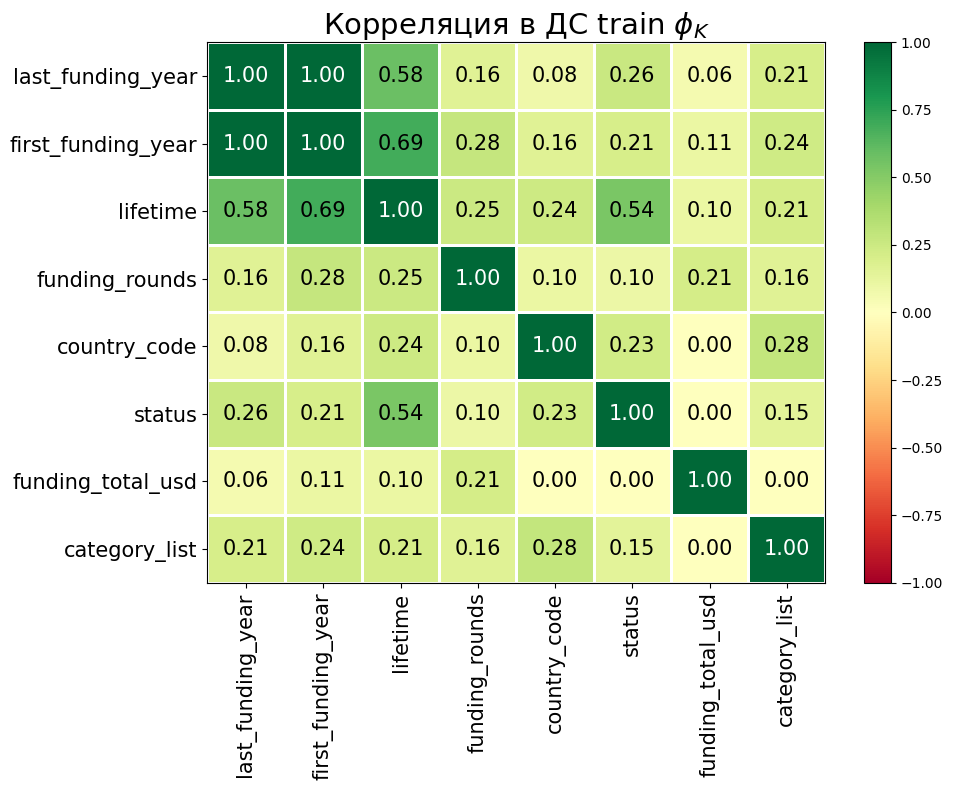

In [592]:
interval_cols = ['lifetime', 'funding_rounds', 'funding_total_usd']

phik_overview = train.drop('name', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция в ДС train $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8))

Отметим мультиколлинеарность между годом первого и последнего финансирования. Соответственно, можем оставить лишь один из признаков. Вероятно, это связано с тем, что большинство стартапов ограничились одним раундом.

Важнее наличие очень сильной связи между скором жизни стартапа и его статусом, что ранее отмечали при анализе. Однако мы не можем говорить о наличии мультиколлинеарности в данном случае (принятое пороговое значение 0,9).

Помимо срока жизни, также наличие линейной зависимости можно отметить между статусом и страной (слабая связь). А вот с объемом финансирования связи не обнаружено, что ранее отмечалось в рамках исследования.

Соответственно, убираем мультиколлинеарные столбцы, оставим только год последнего финансирования. И можем приступать к выбору модели.

In [593]:
train = train.drop('first_funding_year', axis=1)
test = test.drop('first_funding_year', axis=1)

In [594]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   funding_rounds     52516 non-null  int64  
 6   lifetime           52516 non-null  int64  
 7   last_funding_year  52516 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 3.0+ MB


In [595]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   funding_rounds     13125 non-null  int64  
 5   lifetime           13125 non-null  int64  
 6   last_funding_year  13125 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 666.6+ KB


# Разработка модели

## Выбор и обучение моделей

Так как выборки уже разбиты, то нет необходимости делать это. Выделим целевой параметр.

In [596]:
RANDOM_STATE = 40

X_train = train.drop(['name', 'status'], axis=1)
y_train = train['status']

X_test = test.drop('name', axis=1)
y_test = startups['status']

Для оптимизации дальнейшей работы с моделями подготовим пайплайны.

Для кодирования категориальных признаков используем кодировщик OneHotEncoder. Для масштабирования количественных признаков используем 2 скейлера: StandardScaler, MinMaxScaler

Введём обозначения для типов исходных данных:

In [597]:
X_train.head(1)

,category_list,funding_total_usd,country_code,funding_rounds,lifetime,last_funding_year
0,Other,828626.0,CHE,2,2998,2014


In [598]:
ohe_columns = ['category_list', 'country_code']

num_columns = ['funding_total_usd', 'funding_rounds', 'lifetime', 'last_funding_year']

На текущий момент в данных нет пропусков, однако возможно, что они могут появиться в новых данных в дальнейшем, учтем это при формировании пайплайна с помощью SimpleImputer.

In [599]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
], 
   remainder='passthrough')


pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

В данном случае перед нами стоит задача классификации, то есть определить, закроется или нет стартап в будущем.

Для этого будем использовать следующе модели: метод k-ближайших соседей(KNeighborsClassifier), дерево решений (DecisionTreeClassifier) и классификация опорных векторов (SVC). Для каждой подбираем, по возможности, оптимальные гиперпараметры.

За основу проверки качества работы модели возьмем метрику F1.

In [600]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(1,15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

In [601]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='f1_weighted', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [602]:
randomized_search.fit(X_train, y_train)

print('Метрика f1 для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика f1 для лучшей модели:
 0.9741412728795004

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['category_list',
                                                   'country_code']),
                                                 ('n

По итогу оценки 3 моделей, лучший результат дала модель дерева решений (DecisionTreeClassifier) с максимальной глубиной 11, количество объектов на 1 "листе" 13, а минимальное количество объектов на узле для разделения на классы - 8. Метрика f1 на тренировочных данных составила 97.4%, очень высокий показатель.

Фиксируем итоговую модель в финальном пайплайне.

In [603]:
pipe_final_2 = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(max_depth=11, min_samples_leaf=13,
                                          min_samples_split=8, random_state=RANDOM_STATE))
    ])

Оценим работу модели по метрике f1 при кросс-валидации.

In [604]:
result = cross_val_score(pipe_final_2, X_train, y_train, cv=10, scoring='f1_weighted')

pipe_final_2.fit(X_train, y_train)
y_pred = pipe_final_2.predict(X_test)

C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zer

In [605]:
print(f"[Кросс-валидация] Все значения F1: {[round(x,2) for x in result]}")
print(f"[Кросс-валидация] Среднее значение F1: {result.mean():.2f}")
print("[Тестовая выборка] F1: 0.974")
print(f"[Тренировочная выборка] F1: {f1_score(y_test, y_pred, pos_label='operating'):.2f}")

[Кросс-валидация] Все значения F1: [0.97, 0.97, 0.98, 0.97, 0.97, 0.97, 0.97, 0.98, 0.97, 0.97]
[Кросс-валидация] Среднее значение F1: 0.97
[Тестовая выборка] F1: 0.974
[Тренировочная выборка] F1: 0.65


При кросс-валидации значение метрики не снижается, но значительно падает на тренировочных данных. Значит, на высокий результат появлияло то, какие именно значения попали в выборку. Рассмотрим, как распределяются показатели важности признаков.

## Анализ важности признаков лучшей модели

Оценим важность признаков для лучшей модели, построим график важности и рассмотрим его детально.

C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


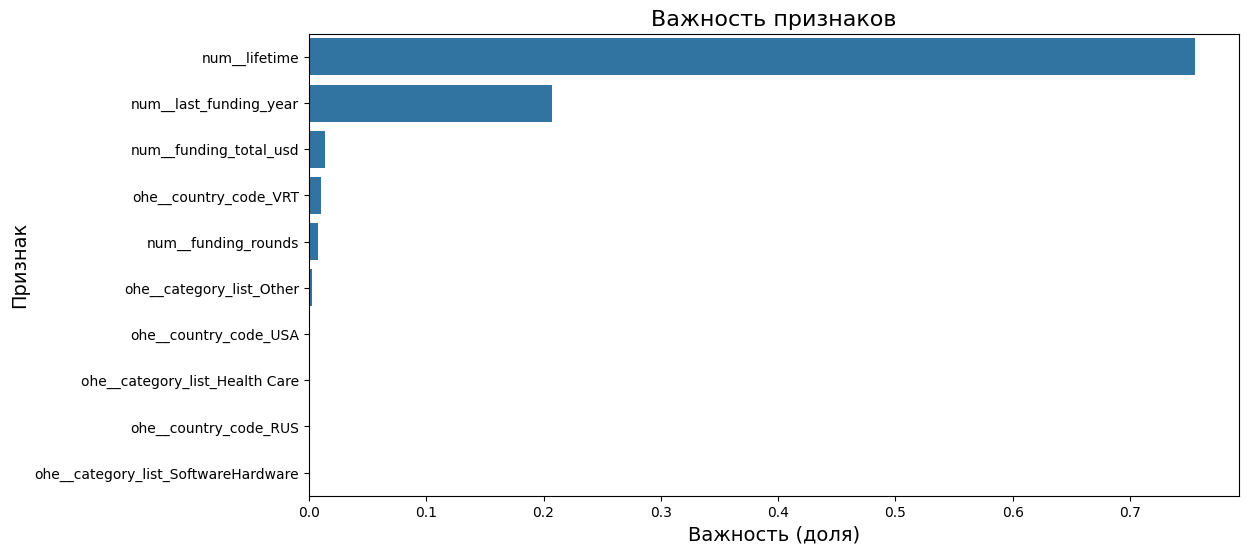

In [607]:
X_train_prep = data_preprocessor.fit_transform(X_train)
X_test_prep = data_preprocessor.transform(X_test)

model = DecisionTreeClassifier(max_depth=11, min_samples_leaf=13, min_samples_split=8, random_state=RANDOM_STATE)
model.fit(X_train_prep, y_train)

feature_importances = pd.DataFrame(
    {
        'Feature': data_preprocessor.get_feature_names_out(),
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances
)


ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Отметим, что модель преимущественно опирается на данные о сроке жизни стартапа. Это ожидаемый исход, т.к. ранее отмечали высокую зависимость от данного показателя. Однако в результате модель сталкивается с переобучением на данном этапе, чрезмерно фокусируясь на цифрах тренировочной выборки. В результате, хотя распределения и очень близки, на тестовых данных результат выходит ниже.

Соответственно, возможно стоит пересмотреть распределение классификации категорий или же пересмотреть показатель lifetime с целью снижения зависимости модели от данного показателя.

# Итоговый отчет

По итогу проведенного анализа удалось установить следующее:
- Наиболее развитыми и подходящими для развития стартапа в период 1980-2018 гг были США, Великобритания и Канада - на их долю приходилось больше всего стартапов. Согласно открытым источникам, на текущий момент данная ситуаия преимущественно сохраняется, однако в ТОПы вырывается также Индия, развивающаяся экономика которой активно продвигает стартапы в области IT.
- Наиболее "проблемыми" и опасными являются первые года жизни стартапа, именно на этот период приходится больше всего закрытий. С течением времени же, закономерно, стартап крепнет и переходит в стадию бизнеса. Исходя из жизненного цикла стартапа, период Seed, когда от начинающего предпринимателя требуется приложить больше всего усилий, является самым трудным.
- При этом размер финансовых вложений извне не оказывает значимого влияния на дальнейшую судьбу стартапа. Более того, большинство стартапов практически не получают значимых сумм финансирования.
- Однако есть стартапы, которые смогли привлечь крайне значительные суммы денег на свое развитие, вплодь до 8 миллиардов долларов.

- Соответственно, ключом к успеху являются готовность и наличие собственных средств (финансовых, моральных и интеллектуальных), чтобы справиться с первыми годами жизни стартапа.
- Направление деятельности может быть любым, но наиболее популярными являются IT направления, стартапы для бизнеса и товары/услуги повседневного потребления.